<a href="https://colab.research.google.com/github/ucalyptus/Cloud-Movers-Distance/blob/main/Wasserstein_Gromov_Wasserstein_Point_Cloud_Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
### Deform a Sphere mesh to a Torus Mesh.
### You can't do that on meshes because changing topology hurts the euler characteristic property of mesh triangulations.
### So sample out point clouds from these meshes and apply OT-based registration techniques

In [4]:
!pip install 'git+https://github.com/forkbabu/POT.git@torch-gromov' open3d trimesh

  Cloning https://github.com/forkbabu/POT.git (to revision torch-gromov) to /tmp/pip-req-build-nbrk23jl
  Running command git clone -q https://github.com/forkbabu/POT.git /tmp/pip-req-build-nbrk23jl
  Running command git checkout -b torch-gromov --track origin/torch-gromov
  Switched to a new branch 'torch-gromov'
  Branch 'torch-gromov' set up to track remote branch 'torch-gromov' from 'origin'.
     |████████████████████████████████| 103.6MB 102kB/s 
     |████████████████████████████████| 634kB 47.8MB/s 
  Created wheel for POT: filename=POT-0.7.0-cp36-cp36m-linux_x86_64.whl size=331541 sha256=c2dba81e44094e08f8710acdb559f9171a3313dedfbc842c2191ac733a68540c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bv5x43_q/wheels/9e/bf/39/df26825ab53670897896d2ef186363cde427ea2b48c861999d
Successfully built POT


In [5]:

import sys
import torch

In [6]:
print(torch.__version__)

1.7.0+cu101


In [7]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118    0   118    0     0    690      0 --:--:-- --:--:-- --:--:--   690
100  404k    0  404k    0     0   807k      0 --:--:-- --:--:-- --:--:--  807k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-lkslonqa
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-lkslonqa
  Running command git checkout -q 18ce14cd31a2f1c99e16d727e1755156c360453a
     |████████████████████████████████| 276kB 13.5MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20510427 sha256=d7ff072edef2db9f9739df2b67c294c52c5de1891a6873dbe09362a181d11d90
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmb4ovsn/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename

In [8]:
import ot
import ot.torch as ott
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere,torus
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [9]:
src_mesh = ico_sphere(4, device)

In [10]:
trg_mesh  = torus(1,2,10,20,device)

In [11]:
def plot_mesh(mesh_obj):
  import trimesh
  final_verts, final_faces = mesh_obj.get_mesh_verts_faces(0)
  mesh = trimesh.Trimesh(vertices=final_verts.detach().cpu().numpy(),faces = final_faces.detach().cpu().numpy())
  return mesh



In [12]:
def plot_pointcloud(mesh,filename,num_points, title="",iter=1):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, num_points)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()
    plt.savefig('{}_{}.png'.format(filename,str(iter)))

# Compute cost matrices for source and target meshes

In [13]:
import pytorch3d

In [14]:
def create_cost_matrix(mesh:pytorch3d.structures.meshes.Meshes):
  import networkx as nx
  import trimesh
  g = nx.Graph()
  final_verts, final_faces = mesh.get_mesh_verts_faces(0)
  mesh = trimesh.Trimesh(vertices=final_verts.detach().cpu().numpy(),faces = final_faces.detach().cpu().numpy())
  g.add_edges_from(mesh.edges_unique)
  Cost_dict = dict(nx.algorithms.shortest_paths.generic.shortest_path_length(g))
  dim = len(final_verts)
  costmat = np.ones((dim,dim),dtype=np.uint8)
  for i in range(0,costmat.shape[0]):
    for j in range(0,costmat.shape[1]):
      costmat[i][j] = int(Cost_dict[i][j])
  return costmat


# **Wasserstein**

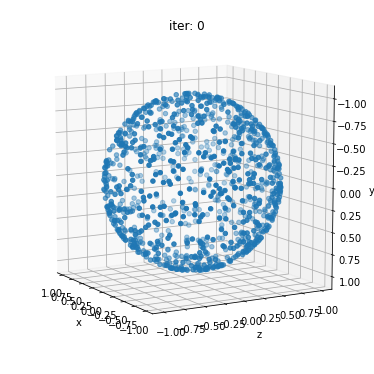

<Figure size 432x288 with 0 Axes>

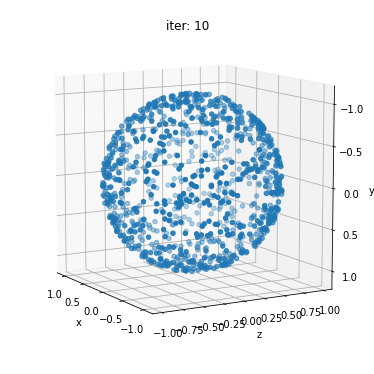

<Figure size 432x288 with 0 Axes>

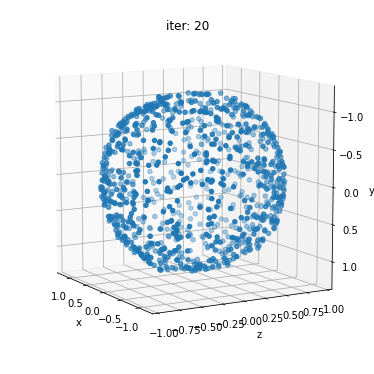

<Figure size 432x288 with 0 Axes>

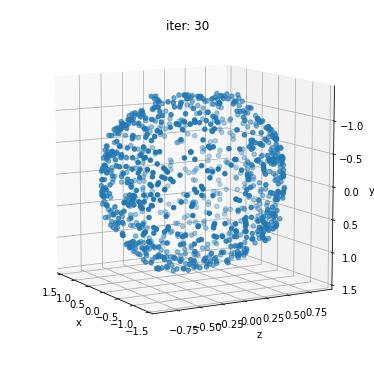

<Figure size 432x288 with 0 Axes>

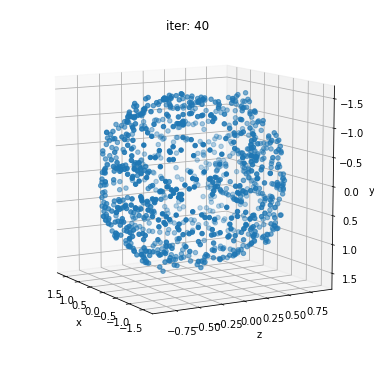

<Figure size 432x288 with 0 Axes>

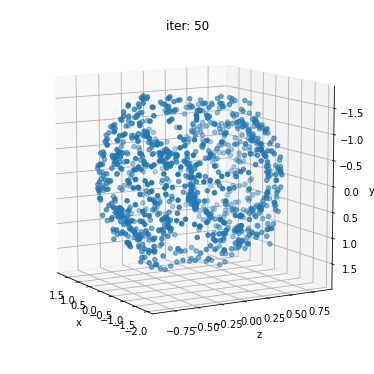

<Figure size 432x288 with 0 Axes>

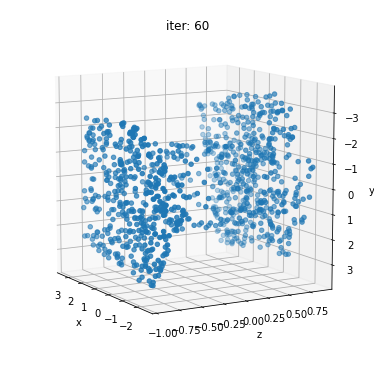

<Figure size 432x288 with 0 Axes>

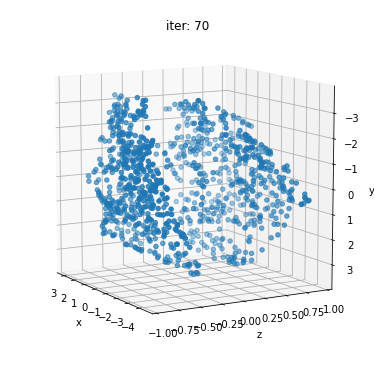

<Figure size 432x288 with 0 Axes>

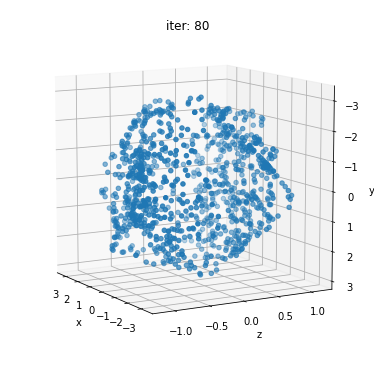

<Figure size 432x288 with 0 Axes>

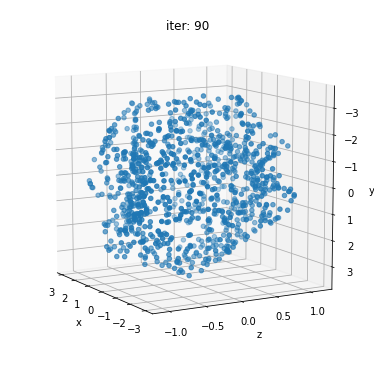

<Figure size 432x288 with 0 Axes>

In [20]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

# Number of optimization steps
Niter = 100

# Plot period for the losses
plot_period = 10
loop = tqdm(range(Niter))

Wass_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_src = sample_points_from_meshes(new_src_mesh, 5000).squeeze(0)
    sample_trg = sample_points_from_meshes(trg_mesh, 5000).squeeze(0)
    
    
    def create_hist(sample_):
      q = torch.ones((sample_.shape[0], ))
      q /= torch.numel(q)
      return q

    p, q = create_hist(sample_src),create_hist(sample_trg)
    cost = ott.dist(sample_src,sample_trg)
    # Weighted sum of the losses
    loss = ott.ot_loss(p,q,cost,num_iter_max=500000)
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    Wass_losses.append(loss)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, 'status',1000,title="iter: %d" % i,iter=i)
        #plot_mesh(new_src_mesh).show()
        
        
    # Optimization step
    loss.backward()
    optimizer.step()

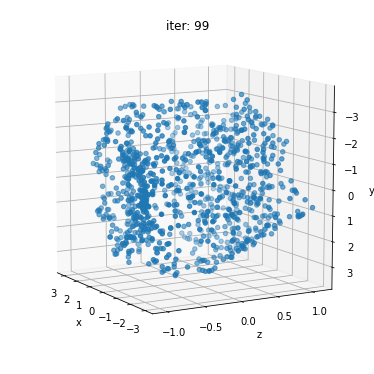

<Figure size 432x288 with 0 Axes>

In [21]:
plot_pointcloud(new_src_mesh, 'status',1000,title="iter: %d" % i,iter=i)

# Not quite a PC sampled from Torus. Two conclusions:
### OT usage is ill-defined for changing homology of objects.
### Topological regularization atop Wass can help. 

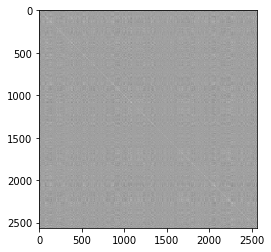

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
C1 = create_cost_matrix(new_src_mesh)
plt.imshow(C1,cmap=plt.cm.Greys)
plt.show()

# **Gromov-Wasserstein**

In [15]:
def otgw_solve(C1,C2,p,q,func='kl_loss'):
    C1 = C1.detach().cpu().numpy().astype(np.float64)
    C2 = C2.detach().cpu().numpy().astype(np.float64)
    p = p.detach().cpu().numpy().astype(np.float64)
    q = q.detach().cpu().numpy().astype(np.float64)
    p /= p.sum()
    q /= q.sum()
    T = gromov_wasserstein2(C1,C2,p,q, log=False,loss_fun=func)
    T = torch.from_numpy(np.asarray(T))
    return T

In [16]:
def calculate_C1(N2,Tr):
  I = torch.ones(N2,1)
  A = I*p.T.unsqueeze(0)
  A = torch.mm(A,C1.type(torch.FloatTensor))
  B = torch.mm(Tr,C2.T.type(torch.FloatTensor))
  grad_C1 = 2*torch.sub(A,B.t())
  return grad_C1

def calculate_C2(N1,Tr):
  I = torch.ones(N1,1)
  A = I*q.T.unsqueeze(0)
  A = torch.mm(A,C2.type(torch.FloatTensor))
  B = torch.mm(Tr.T,C1.type(torch.FloatTensor))
  grad_C2 = 2*torch.sub(A,B.t())
  return grad_C2


In [17]:
import numpy as np
import torch
from torch.autograd import Function
from ot.gromov import gromov_wasserstein2
from torch.autograd import Variable

class GromovWassersteinLossFunction(Function):
    """Return GW Loss for input (C1,C2,p,q) """

    @staticmethod
    def forward(ctx, C1,C2,p,q):

        # convert to numpy
        C1 = C1.detach().cpu().numpy().astype(np.float64)
        C2 = C2.detach().cpu().numpy().astype(np.float64)
        N1,N2 = p.shape[0],q.shape[0]
        p = p.detach().cpu().numpy().astype(np.float64)
        q = q.detach().cpu().numpy().astype(np.float64)
        p /= p.sum()
        q /= q.sum()
        gwdist,log= gromov_wasserstein2(C1,C2,p,q,loss_fun='square_loss',log=True)
        Tr = torch.from_numpy(log['T']).type(torch.FloatTensor)
        alpha = calculate_C1(N2,Tr)
        beta =  calculate_C2(N1,Tr)
        grad_C1 = torch.mm(beta,alpha)
        grad_C2 = torch.mm(alpha,beta)
        grad_C1 /=grad_C1.mean()
        grad_C2 /=grad_C2.mean()
        p = Variable(torch.from_numpy(p), requires_grad=False)
        q = Variable(torch.from_numpy(q), requires_grad=False)
        gwloss = Variable(torch.from_numpy(np.asarray(gwdist)), requires_grad=True)
        ctx.save_for_backward(grad_C1,grad_C2,p,q)
        return gwloss

    @staticmethod
    def backward(ctx, grad_output):

        grad_C10,grad_C20 ,p0,q0= ctx.saved_tensors
        grad_C1,grad_C2 ,p,q= None,None,None,None
        if ctx.needs_input_grad[0]:
          grad_C1 = grad_C10
        if ctx.needs_input_grad[1]:
          grad_C2 = grad_C20
        if ctx.needs_input_grad[2]:
          p = p0
        if ctx.needs_input_grad[3]:
          q = q0
        
        return grad_C1,grad_C2,p,q



def GW(C1,C2,p,q):
    """loss=gromov_wasserstein(C1,C2,p,q)"""
    return GromovWassersteinLossFunction.apply(C1,C2,p,q)


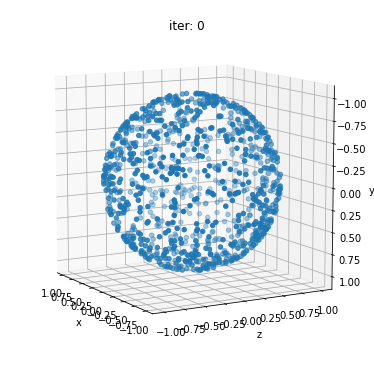

<Figure size 432x288 with 0 Axes>

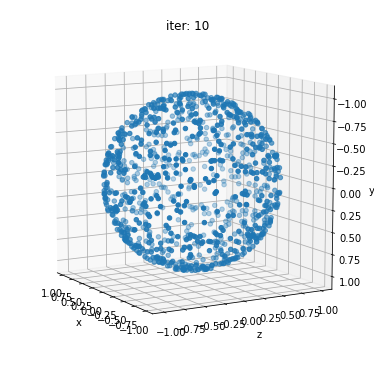

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [18]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

# Number of optimization steps
Niter = 100
%matplotlib inline
# Plot period for the losses
plot_period = 10
loop = tqdm(range(Niter))
import torch


GWass_losses = []

def create_hist(shape):
  q = torch.ones((shape, ))
  q /= torch.numel(q)
  return q

%matplotlib inline
C2 = torch.from_numpy(create_cost_matrix(trg_mesh))
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

  
    p, q = create_hist(new_src_mesh.verts_list()[0].shape[0]),create_hist(trg_mesh.verts_list()[0].shape[0])
    C1 = torch.from_numpy(create_cost_matrix(new_src_mesh).astype(float))
    C1 = Variable(C1, requires_grad=True)
    loss = GW(C1,C2,p,q)
    
    # Print the losses
    loop.set_description('total_loss = %.7f' % loss)
    
    # Save the losses for plotting
    GWass_losses.append(loss)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, 'status',1000,title="iter: %d" % i,iter=i)
        #plot_mesh(new_src_mesh).show()
        
        
    # Optimization step
    loss.backward()
    optimizer.step()

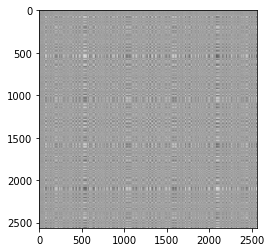

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
C1 = create_cost_matrix(src_mesh)
plt.imshow(C1,cmap=plt.cm.Greys)
plt.show()